In [63]:
import numpy as np
import pandas as pd

In [64]:
DATA_FOLDER = "../../data/"
CAMS_FOLDER = DATA_FOLDER + "cams/"

df = pd.read_csv(CAMS_FOLDER + "3_mar.csv")
props = pd.read_csv(CAMS_FOLDER + "shape_properties.csv")

In [65]:
aodSums = None
AODs = [column for column in df.columns if "aod" in column and column != "aod550"]

for aod in AODs:
    if aodSums is None:
        aodSums = df[aod].copy()
    else:
        aodSums += df[aod]
        
for aod in AODs:
    df[aod] /= aodSums
    
humid = df["t2m"].copy()
dew = df["d2m"]

humid = np.exp(-2.501e6*(humid - dew)/(461.5*humid*dew))

df["hum"] = humid

df["msl"] /= 101325.0 # Pa -> atm (Standard atmosphere at sea level)

df["t2m"] /= 273.15 # 0 Celsius at 1.0
df["d2m"] /= 273.15 # 0 Celsius at 1.0

# kg/m^3 -> µg/m^3
df["pm1"] *= 10**9
df["pm2p5"] *= 10**9
df["pm10"] *= 10**9

# To nearest unit
tcs = [column for column in df.columns if column[:2] == "tc"]
for tc in tcs:
    maxLog = np.log10(df[tc].max())//3
    
    maxLog *= 3
    
    df[tc] *= 10**-maxLog

df["time"] = pd.to_datetime(df["time"])

df = df.sort_values(["shapeID","time"])

df.describe()

,shapeID,amaod550,aod550,bcaod550,d2m,duaod550,msl,niaod550,omaod550,pm1,...,tc_ch4,tc_hno3,tc_no,tc_oh,tc_pan,tcco,tchcho,tcno2,tcso2,hum
count,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,8.015360e+05,801536.000000,801536.000000,...,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000,801536.000000
mean,1616.491955,0.033655,0.171370,0.065331,1.014407,0.050681,1.005259,1.054058e-01,0.271385,5.863226,...,9.788153,4.484838,0.890661,5.693471,4.725514,0.874242,1.559357,4.105087,6.612757,0.718376
std,933.012398,0.025897,0.100270,0.030725,0.033191,0.054792,0.008051,9.383697e-02,0.095710,4.620642,...,0.597950,1.834206,0.888132,2.980267,1.387054,0.097690,0.857158,1.975063,9.984777,0.196039
min,0.000000,0.000000,0.011206,0.003497,0.856562,0.000275,0.966145,9.989304e-07,0.009705,0.000114,...,6.671507,0.422930,0.035272,1.315840,0.174463,0.410619,0.099439,0.545653,0.039924,0.051807
25%,808.750000,0.013050,0.100671,0.043644,0.989638,0.020651,0.999694,3.162484e-02,0.202023,2.890527,...,9.680226,3.311909,0.044748,3.125710,3.874565,0.814943,0.916612,2.585339,1.637251,0.578084
50%,1616.500000,0.028729,0.147478,0.059347,1.009944,0.034423,1.004907,8.154550e-02,0.265391,4.834192,...,9.963910,4.103668,0.687265,3.824193,4.806205,0.883431,1.362685,3.937846,3.299405,0.747320
75%,2424.250000,0.048596,0.215955,0.080946,1.039671,0.058576,1.010410,1.534983e-01,0.334029,7.632936,...,10.161827,5.205684,1.672552,8.862144,5.640946,0.940868,2.037977,5.175374,7.130008,0.885324
max,3232.000000,0.210055,1.787048,0.302857,1.093191,0.807036,1.039456,7.349640e-01,0.790830,411.726180,...,10.651559,61.641285,26.808737,13.022490,33.247215,2.521485,28.240262,40.309236,164.265517,1.000183


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f250d480320>,
      dtype=object)

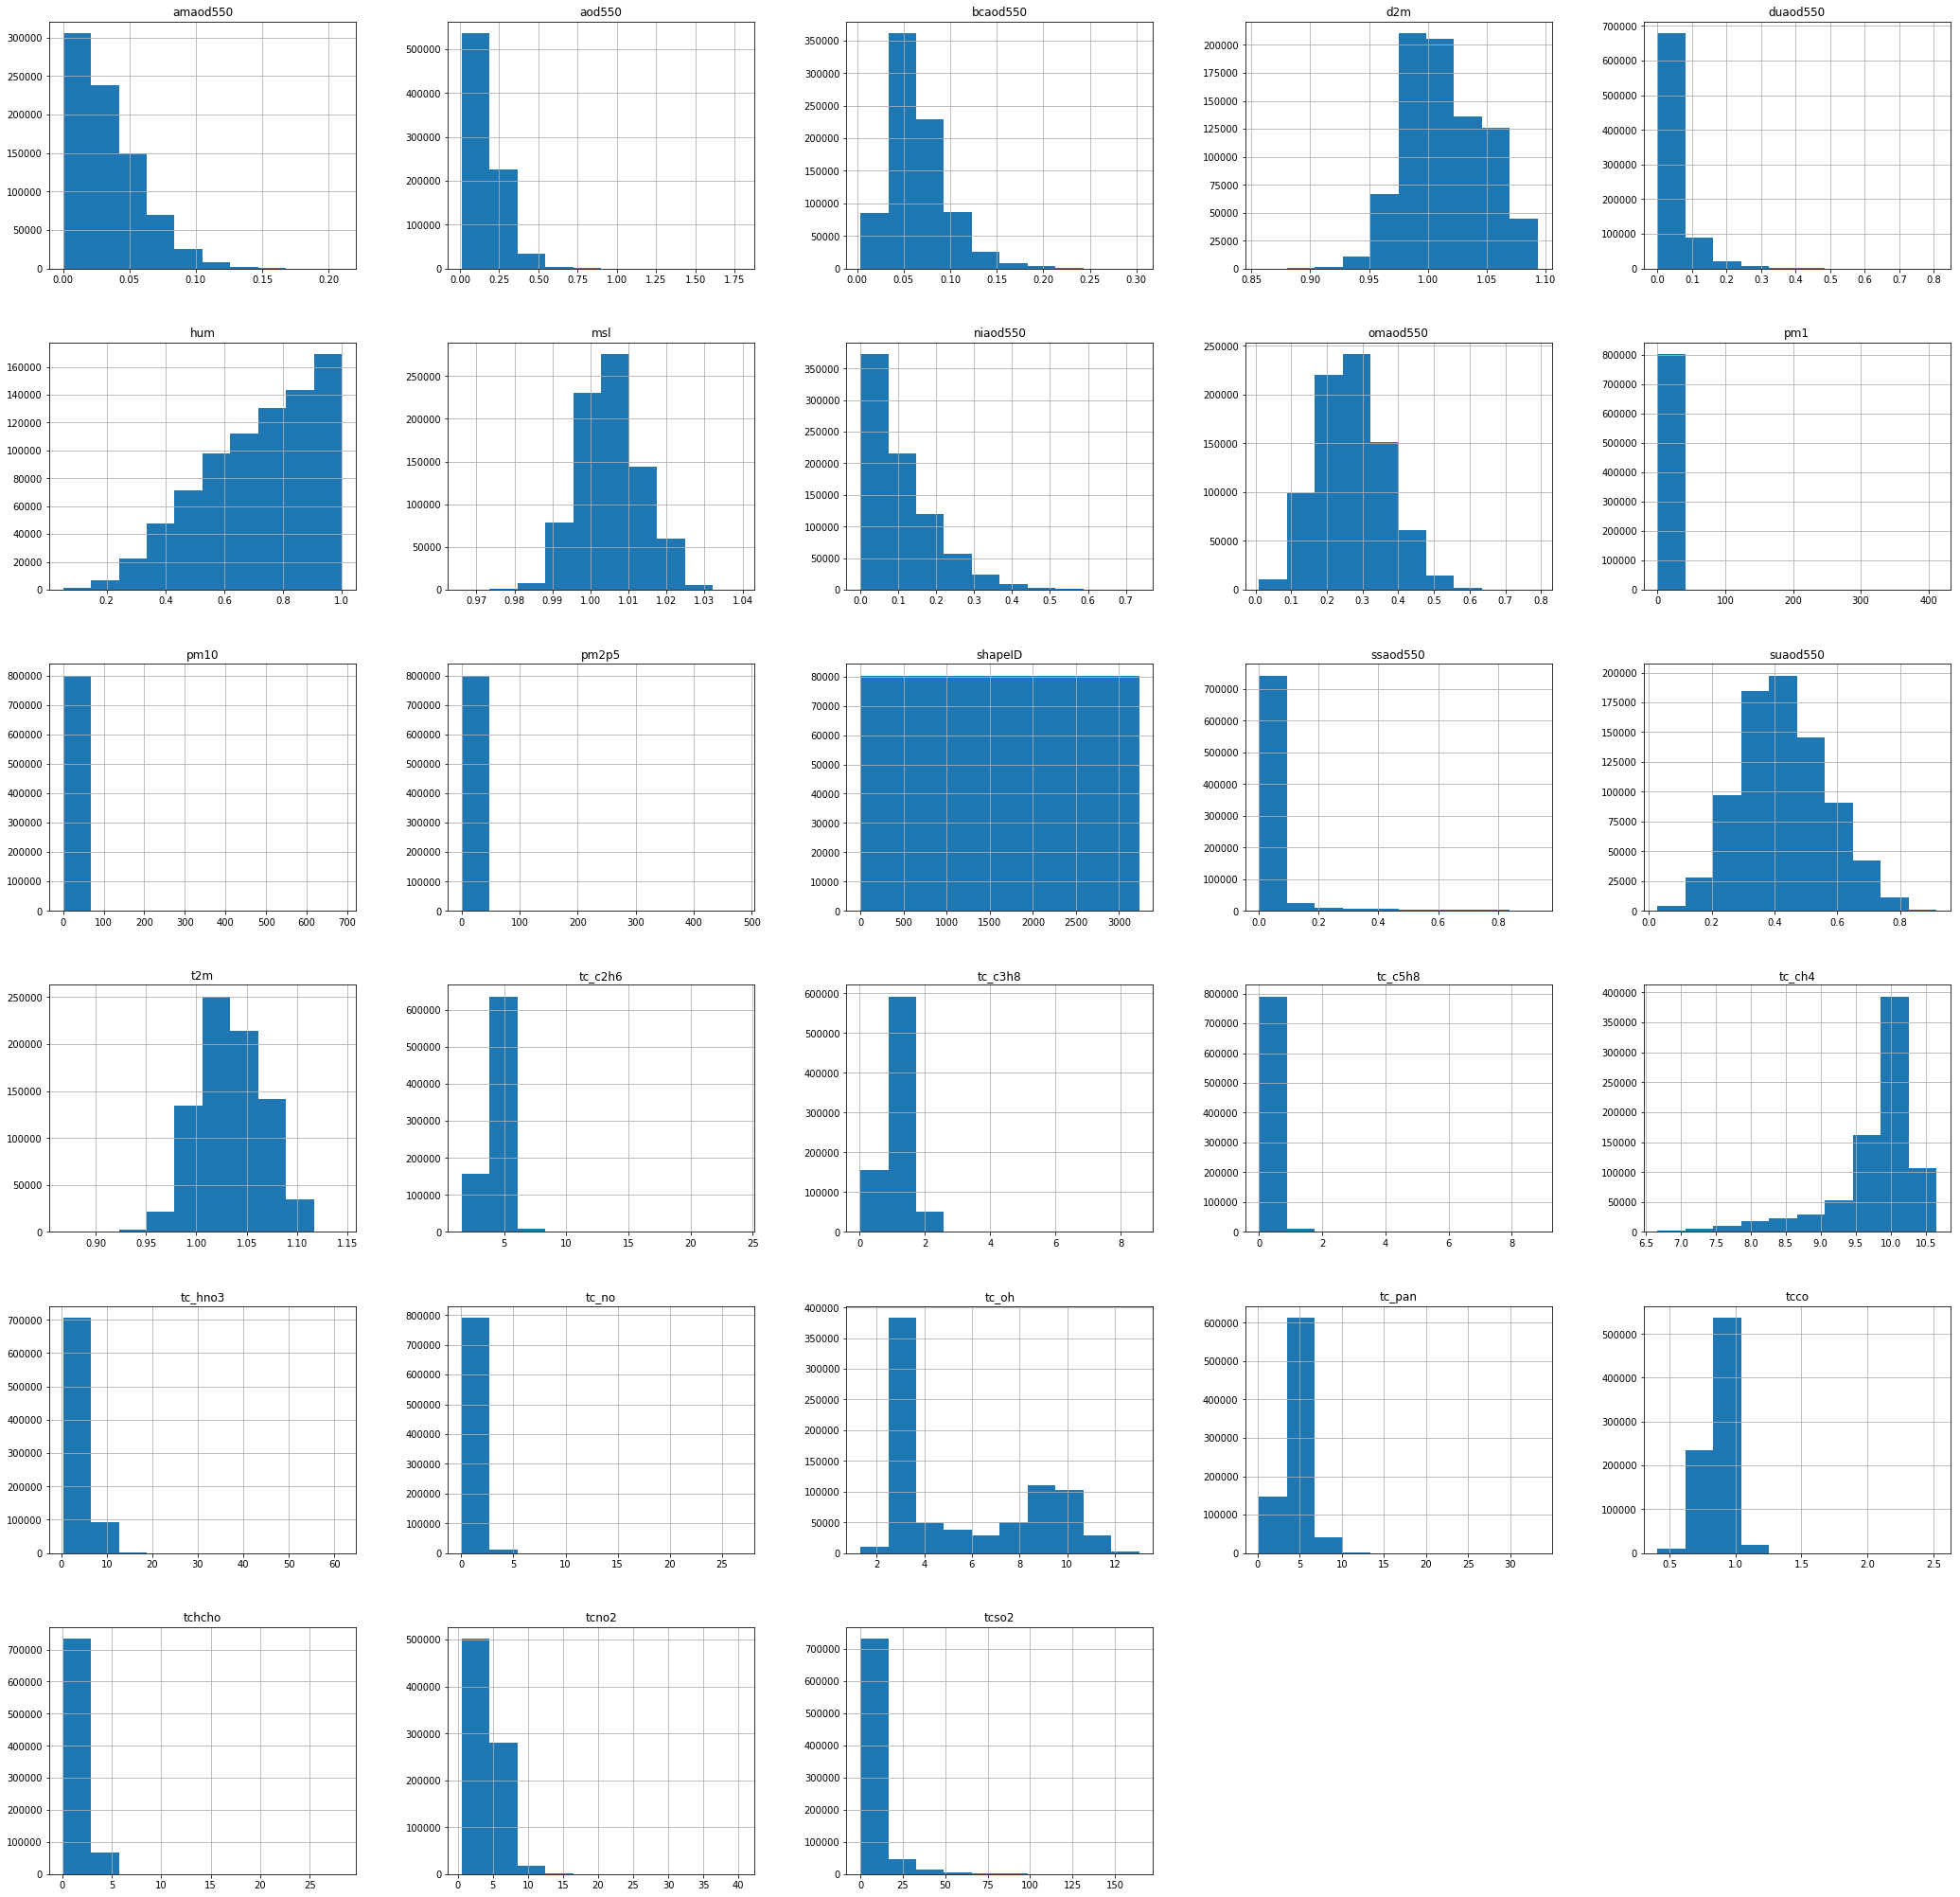

In [66]:
df.hist(figsize=(36,36))

In [67]:
df_std = df.copy()
pms = ["pm1","pm2p5","pm10"]

for tc in tcs:
    df_std[tc] = np.log10(df_std[tc] + max(1e-15,min(df_std[tc])))

for pm in pms:
    df_std[pm] = np.log10(df_std[pm] + max(1e-15,min(df_std[pm])))

df_std["aod550"] = np.log(df_std["aod550"] + max(1e-15,min(df_std["aod550"])))

In [68]:
# no null vals in CAMS
print(  df.isnull().values.any(),
        df_std.isnull().values.any())

False False


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f25510a7390>,
      dtype=object)

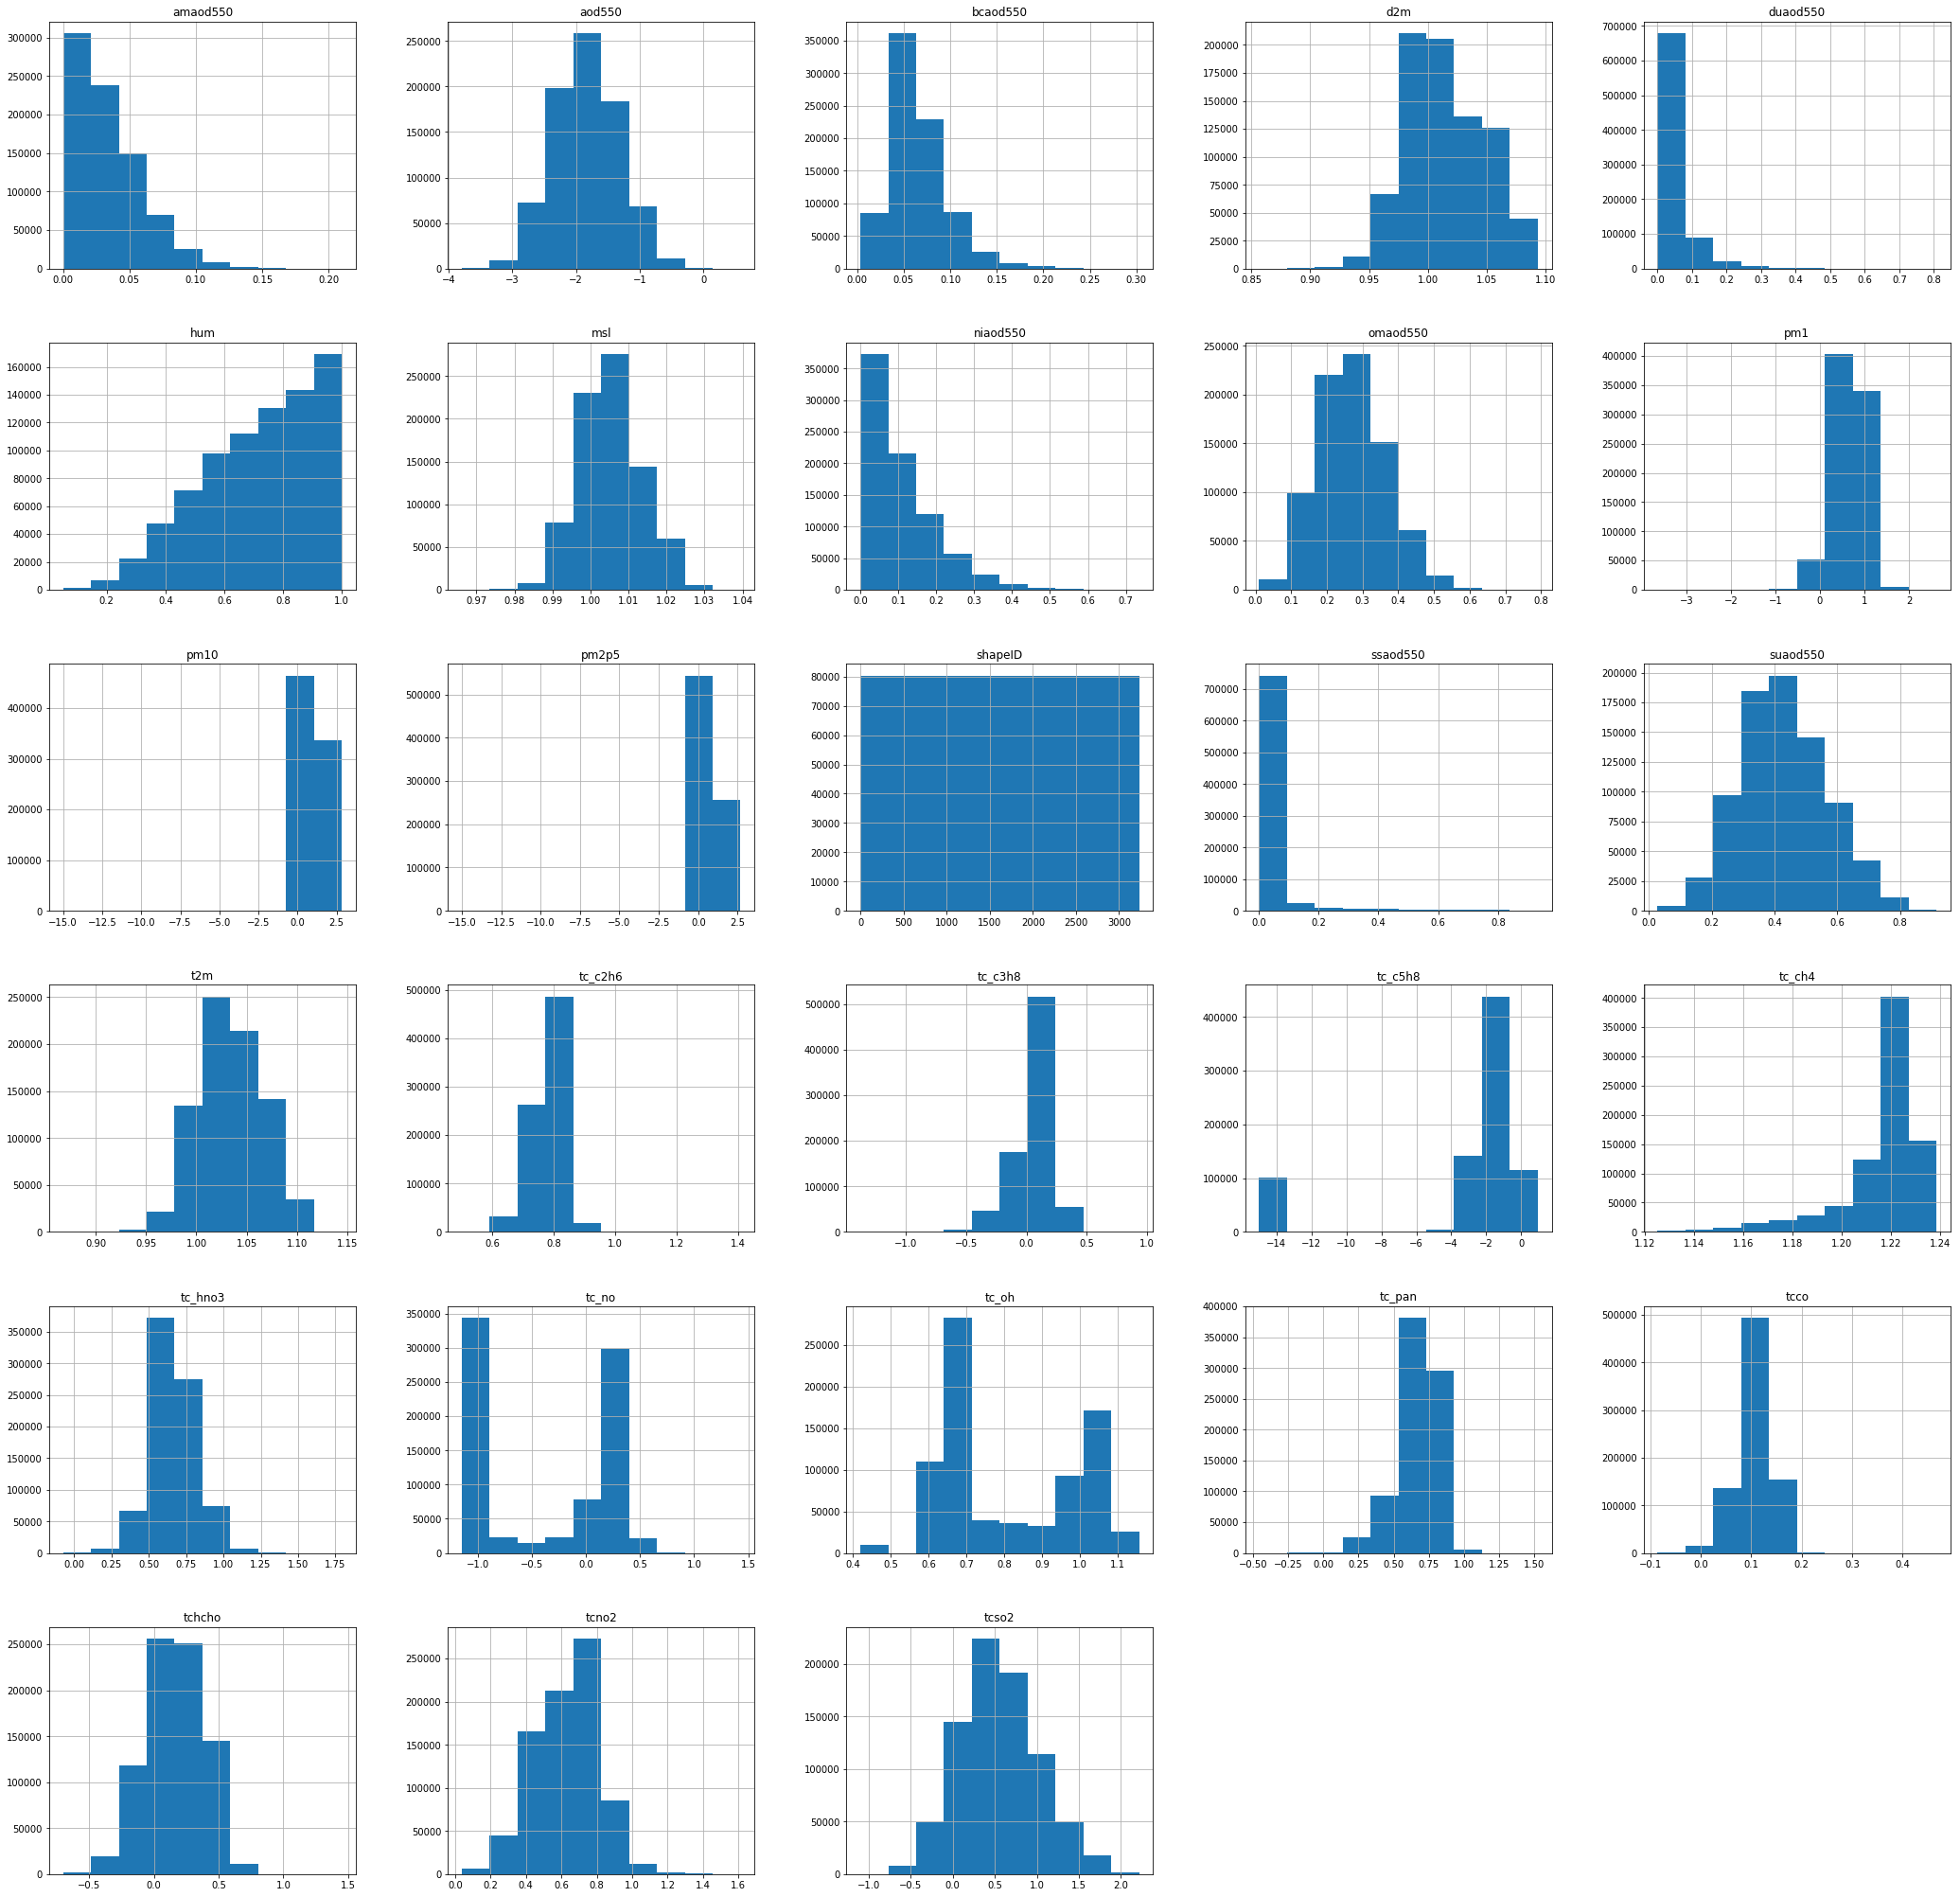

In [69]:
df_std.hist(figsize=(36,36))

#### Plot to see use of PCA

In [70]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt

N_PC = 14

col_names = ["pm2p5","aod550", "t2m","d2m","msl"]
col_names.extend(tcs)

data_matrix = np.array(df_std[ind_vars2].values)
data_matrix_std = scale(data_matrix)

explained_variance_by_axis = PCA(n_components=N_PC).fit(data_matrix_std).explained_variance_ratio_
cum_variance = np.cumsum(explained_variance_by_axis)

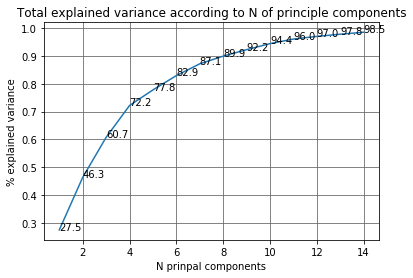

In [71]:

x = range(1, N_PC+1)
y = cum_variance

plt.plot(x, y)
plt.grid(b=True, which='major', color='#666666', linestyle='-')
plt.title("Total explained variance according to N of principle components")
plt.xlabel("N prinpal components")
plt.ylabel("% explained variance")
for a,b in zip(x, y): 
    plt.text(a, b, str(round(b*100,1)))
plt.show()

We see that at 8 pcs we gather 90% of total $\sigma^2$

In [72]:
N_PC = 8
data = data_matrix_std

ind_vars = ["pm2p5","aod550", "t2m","d2m","msl"]
ind_vars.extend(tcs)
PCA_model = PCA(n_components=N_PC).fit(data)
x_vars = PCA_model.transform(data)

X = pd.DataFrame()
for i in range(N_PC):
    X["x"+str(i)] = x_vars[:,i]
print(X)

              x0        x1        x2        x3        x4        x5        x6  \
0      -0.995943  1.378606  0.271955  2.082092  0.728706 -0.394466  0.352936   
1      -1.996052  0.524807 -1.111658  2.140480  0.854442 -0.200351  0.057203   
2      -2.469534 -0.387217 -1.071644  1.945090  1.093166  0.116882  0.136806   
3      -2.404889 -0.111284 -1.437300  1.162953 -0.050215  2.171488  1.212357   
4      -2.764184 -1.612312 -1.383007 -0.891592 -0.415790  1.971430  1.505867   
5       0.106332 -1.251523  1.334970 -0.271944 -0.397979  0.126550 -0.332789   
6       0.953477 -1.253418  1.902185 -0.612364 -0.183036  0.366466  0.149684   
7       1.159679 -1.089059  1.677786 -0.555484  0.082256  0.464087  0.023794   
8      -0.088357 -2.089020 -0.083865 -0.653233  0.815281  0.175352  0.254020   
9      -0.783470 -2.113684 -1.535363 -0.899056  0.584028 -0.050966 -0.083943   
10     -0.695218 -2.034863 -1.706920 -1.095795  0.466622 -0.032672 -0.428024   
11     -0.313481 -0.979246 -1.654258 -0.

In [73]:
X.to_csv(DATA_FOLDER + "X/cams_data.csv")